### Referrals as a f(x) of student performance and how much the student likes the platform.

This is another version of the file, where Andrew successfully was able to print the ROC curves.

In [ ]:
#Step 1: imports
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn import datasets,metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score, classification_report)
import matplotlib.pyplot as plt

import os

# Get the notebook directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Set the working directory
os.chdir(notebook_dir)

In [ ]:
#Step 2: Load dataset
df = pd.read_csv('tutoring_data.csv')
df.head()

,User_ID,Age_in_Months,Gender,Location,Grade,Logins_per_Month,Days_Completed_Activity,Exercises_Started,Total_Time_Spent_in_Minutes,Course_Name,...,Recommendation_Likelihood,Exercises_Completed,Points_Earned,Subscription_Tier,Subscription_Cost,Subscription_Length_in_Months,Renewal_Status,Tutoring,Referrals,Academic_Grade
0,654b113d-4ce4-41a9-a8f4-7f1419419230,156,Other,"Smithchester, VA",8th Grade,6,5,9.784359,107.889381,Chemistry,...,3,7,1910.292936,Free,0.00,4,Yes,Yes,0,D
1,2a044973-1d29-4b2f-83f6-c488290140bb,202,Female,"Beckside, FL",10th Grade,6,6,9.000000,198.865171,Web Development,...,4,9,1698.767255,Free,0.00,1,Yes,No,0,F
2,d84bb18b-bd77-4be9-98bb-a0993b95af75,173,Other,"New Deborahborough, SD",9th Grade,7,4,12.159345,232.639784,Geometry,...,4,10,1860.295769,Premium,9.99,13,Yes,No,0,D
3,411cebf6-18cc-4846-89c7-f3f7bcaede01,199,Female,"West Stephanie, KY",12th Grade,17,17,28.000000,506.644691,Pre-Calculus,...,3,28,4465.824908,Basic,5.99,11,Yes,No,1,F
4,e4ada708-10b6-4fcd-ac08-a83152658751,148,Female,"West Roberthaven, LA",7th Grade,10,8,15.458939,305.275706,Java Programming,...,4,17,2499.211664,Premium,9.99,12,Yes,No,0,F


In [ ]:
#Step 3: Training and test set:

#1st: Extract integer from grade.
df['Grade'] = df['Grade'].str.extract('(\d+)') #To assign the extracted grades to replace the original Grade column.
#df['Grade'].str.extract('(\d+)') #By itself doesn't work since returns a dataframe (just a column of row numbers and a column of the extracted grades)

df.head()
#print(df) #Prints the addresses of the values in the table.

#3rd: Det. x and y.
x = df[['Age_in_Months', 'Grade', 'Points_Earned', 'Logins_per_Month']] #Prev. error: 1st: had 'Age_in_Months ' --> extra space before quote. 2nd: Need double brackets when selecting >1 col.
y = df['Referrals']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Display the shapes of the resulting datasets to verify the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11874, 4), (2969, 4), (11874,), (2969,))

#### Now the difference: change the weights of the classifier eqn for the classes (see the parameters).

In [ ]:
#Step 4: Create the Multi-class regression problem:

#4.1 Need to normalize data:
modelName = Pipeline([
    ('scale', StandardScaler()),
    ('LogReg', OneVsRestClassifier(LogisticRegression(class_weight='balanced'))) #This is optional parameter. If you don't select iter size, function will use default.
    ])

modelName.fit(X_train, y_train)
modelName_pred = modelName.predict(X_test)
modelName_prob = modelName.predict_proba(X_test)

trainingAccuracyBeforeCV = accuracy_score(y_test, modelName_pred)
print("Accuracy", trainingAccuracyBeforeCV)
trainingError = 1- trainingAccuracyBeforeCV
print("Training errorBeforeCV", trainingError)

Accuracy 0.288986190636578
Training errorBeforeCV 0.711013809363422


In [ ]:
# Modified to perform feature selection on most features
df.drop(columns=['User_ID','Location','Course_Name','Subscription_Tier','Gender','Course_Category','Academic_Grade'], inplace=True)
df.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

x = df.drop(columns=['Referrals'])
y = df['Referrals']



X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
forwardFS = SequentialFeatureSelector(modelName,
                                      k_features='best',
                                      forward=True,
                                      verbose = 2,
                                      scoring='average_precision',
                                      cv=15)
forwardFS_model = forwardFS.fit(X_train, y_train)



<ipython-input-5-2a8a5701c51a>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

[2024-12-01 16:59:39] Features: 1/16 -- score: 0.2608659715016935
[2024-12-01 17:00:10] Features: 2/16 -- score: 0.2642745878291729
[2024-12-01 17:00:30] Features: 3/16 -- score: 0.2632300925124063
[2024-12-01 17:00:48] Features: 4/16 -- score: 0.2634417193246676
[2024-12-01 17:01:08] Features: 5/16 -- score: 0.26278700613694245
[2024-12-01 17:01:29] Features: 6/16 -- score: 0.26117631328090574
[2024-12-01 17:01:48] Features: 7/16 -- score: 0.26157787623199513
[2024-12-01 17:02:07] Features: 8/16 -- score: 0.26116993663897875
[2024-12-01 17:02:25] Features: 9/16 -- score: 0.260515872852318
[2024-12-01 17:02:43] Featur

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

def plot_multiclass_roc(y_true, y_score, classes):
    """
    Plots the ROC curve for multi-class classification.

    Parameters:
    - y_true: array-like, shape (n_samples,)
        True class labels.
    - y_score: array-like, shape (n_samples, n_classes)
        Predicted probabilities for each class.
    - classes: list of str
        List of class names.

    Returns:
    - None: Displays the ROC curve plot.
    """
    # Binarize the output labels
    y_true_binarized = label_binarize(y_true, classes=range(len(classes)))

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

def plot_multiclass_precision_recall(y_true, y_score, classes):
    """
    Plots the Precision-Recall curve for multi-class classification.

    Parameters:
    - y_true: array-like, shape (n_samples,)
        True class labels.
    - y_score: array-like, shape (n_samples, n_classes)
        Predicted probabilities for each class.
    - classes: list of str
        List of class names.

    Returns:
    - None: Displays the Precision-Recall curve plot.
    """
    # Binarize the output labels
    y_true_binarized = label_binarize(y_true, classes=range(len(classes)))

    # Compute Precision-Recall curve and average precision for each class
    precision = {}
    recall = {}
    average_precision = {}

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i])

    # Compute micro-average Precision-Recall curve and average precision
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_true_binarized.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(y_true_binarized, y_score, average="micro")

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    """
    Plots a confusion matrix for multi-class classification.

    Parameters:
    - y_true: array-like, shape (n_samples,)
        True class labels.
    - y_pred: array-like, shape (n_samples,)
        Predicted class labels.
    - classes: list of str
        List of class names.
    - normalize: bool, default=False
        If True, normalize the confusion matrix by row (i.e., by the number of actual instances in each class).

    Returns:
    - None: Displays the confusion matrix plot.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap='Blues', values_format=fmt)



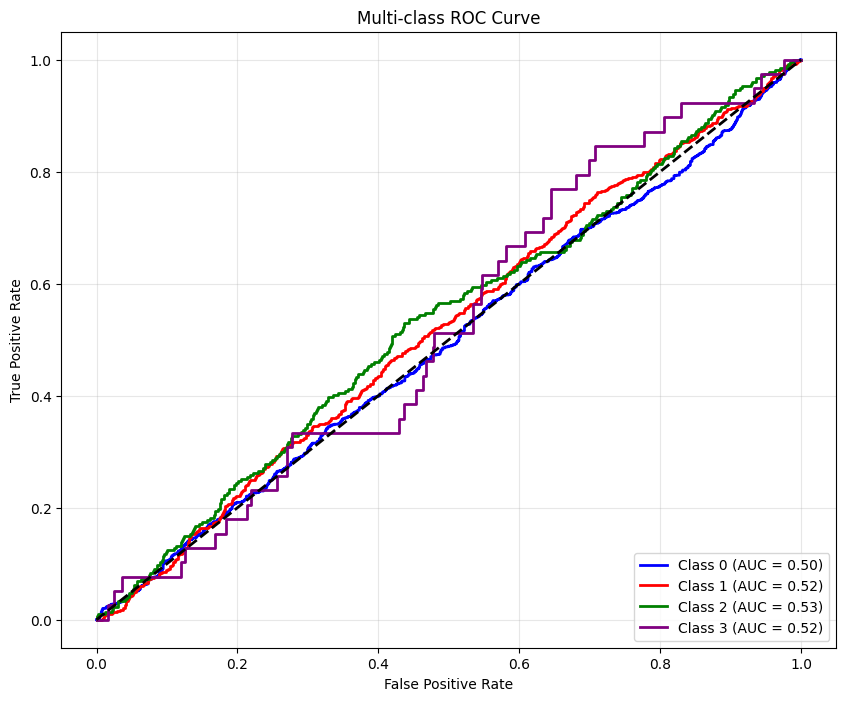

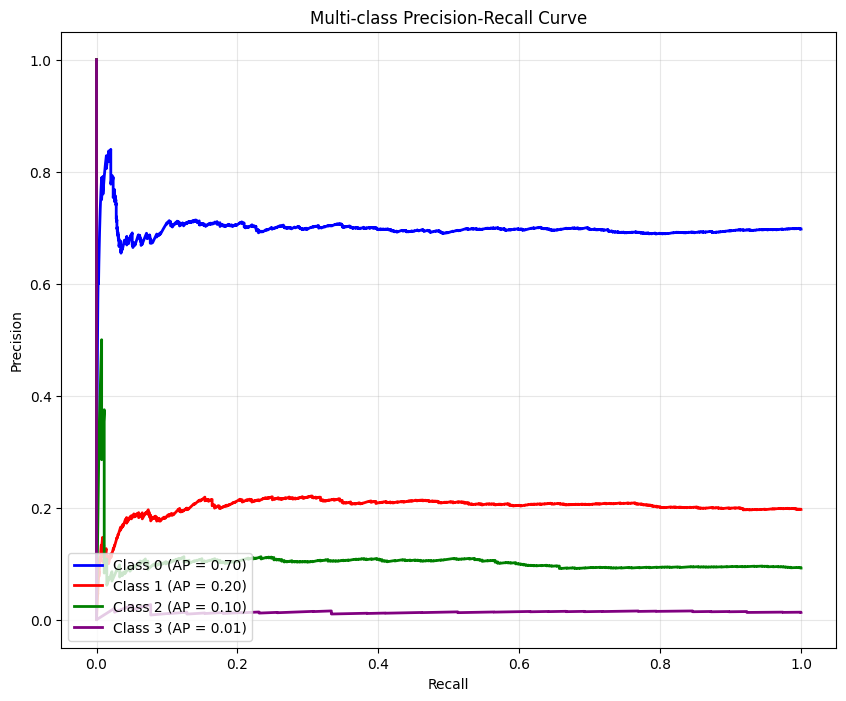

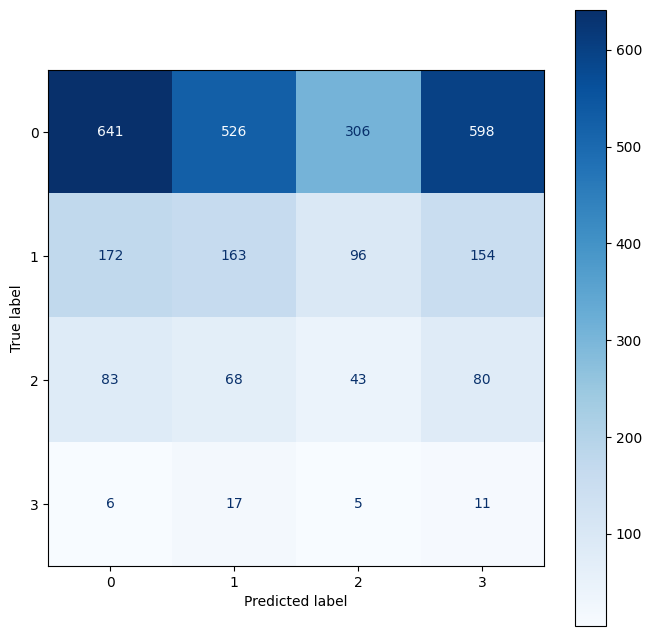

In [ ]:
class_labels = [0,1,2,3]
plot_multiclass_roc(y_test, modelName_prob, class_labels)
plot_multiclass_precision_recall(y_test, modelName_prob, class_labels)
plot_confusion_matrix(y_test, modelName_pred, class_labels)

In [ ]:
# Binarize the output labels for ROC curve
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

y_score = modelName.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = [0 for n in range(n_classes)]
tpr = [0 for n in range(n_classes)]
roc_auc = [0 for n in range(n_classes)]

print(n_classes)


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot macro-average ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall ROC')
plt.legend(loc="lower right")
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Average_Score
- Completion_Rate
- Course_Rating
- Days_Completed_Activity
- Exercises_Completed
- ...
